In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [2]:
BATCH_SIZE=64


# Data Preperation

In [3]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)


In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [6]:

def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [7]:
standardization(tf.constant("In the movie?, man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you? T"))


<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [8]:

VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

In [9]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)


In [10]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data


In [11]:
len(vectorize_layer.get_vocabulary())


10000

In [12]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [13]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [14]:
vectorize_layer.get_vocabulary()[411]


'absolutely'

In [15]:

for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [16]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


In [17]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Modeling


# Transformers

# Embeddings

In [19]:
def positional_encoding(model_size,SEQUENCE_LENGTH):
  output=[]
  for pos in range(SEQUENCE_LENGTH):
    PE=np.zeros((model_size))
    for i in range(model_size):
      if i%2==0:
        PE[i]=np.sin(pos/(10000**(i/model_size)))
      else:
        PE[i]=np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE,axis=0))
  out=tf.concat(output,axis=0)
  out=tf.expand_dims(out,axis=0)
  return tf.cast(out,dtype=tf.float32)

In [20]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim,):
    super(Embeddings, self).__init__()
    self.token_embeddings=Embedding(
        input_dim=vocab_size, output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions=positional_encoding(
        self.embed_dim,self.sequence_length)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

  def get_config(self):
      config = super().get_config()
      config.update({
        "sequence_length": self.sequence_length,
        "vocab_size": self.vocab_size,
        "embed_dim": self.embed_dim,
      })
      return config

In [21]:
test_input=tf.constant([[  2, 112,   10,   12,  5,   0,   0,   0,]])

emb=Embeddings(8,20000,256)
emb_out=emb(test_input)
print(emb_out.shape)

(1, 8, 256)


<!-- Encoder -->


# Encoder

In [22]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads,):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim,
        )
        self.dense_proj=tf.keras.Sequential(
            [Dense(dense_dim, activation="relu"),Dense(embed_dim),]
        )
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
      if mask is not None:
        mask1 = mask[:, :, tf.newaxis]
        mask2 = mask[:,tf.newaxis, :]
        padding_mask = tf.cast(mask1&mask2, dtype="int32")

      attention_output = self.attention(
          query=inputs, key=inputs,value=inputs,attention_mask=padding_mask
      )

      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
      config = super().get_config()
      config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
      })
      return config

In [23]:
encoder_outputs = TransformerEncoder(256,2048,2)(emb_out)
print(encoder_outputs.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


(1, 8, 256)


Transformer Model


In [24]:
EMBEDDING_DIM=128
D_FF=1024
NUM_HEADS=8
NUM_LAYERS=1
NUM_EPOCHS=20


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, MultiHeadAttention

class TransformerEncoder(Layer):
    def __init__(self, embedding_dim, d_ff, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.d_ff = d_ff
        self.num_heads = num_heads

        # Define sub-layers
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
        self.ffn = Dense(d_ff, activation="relu")
        self.output_dense = Dense(embedding_dim)
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        # Called once the layer is used, enabling flexible input shapes
        super(TransformerEncoder, self).build(input_shape)

    def call(self, inputs, mask=None):
        # Initialize padding_mask to None by default
        padding_mask = None

        # If a mask is provided, define padding_mask based on it
        if mask is not None:
            padding_mask = tf.cast(mask, dtype=tf.bool)

        # Multi-head attention layer
        attention_output = self.attention(query=inputs, key=inputs, value=inputs, attention_mask=padding_mask)
        attention_output = self.layernorm1(inputs + attention_output)

        # Feed-forward network
        ffn_output = self.ffn(attention_output)
        ffn_output = self.output_dense(ffn_output)
        ffn_output = self.layernorm2(attention_output + ffn_output)

        return ffn_output

    def get_config(self):
        base_config = super(TransformerEncoder, self).get_config()
        return {**base_config, "embedding_dim": self.embedding_dim, "d_ff": self.d_ff, "num_heads": self.num_heads}


In [35]:
# Define inputs and embedding layer
from tensorflow.keras.regularizers import l2

encoder_input = Input(shape=(None,), dtype="int64", name="encoder_input")
x = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(encoder_input)

# Apply multiple Transformer Encoder layers with dropout
for _ in range(NUM_LAYERS):
    x = TransformerEncoder(EMBEDDING_DIM, D_FF, NUM_HEADS)(x)
    x = Dropout(0.3)(x)  # Add dropout after each transformer encoder

# Use GlobalMaxPooling1D instead of Flatten
x = GlobalMaxPooling1D()(x)
x = Dropout(0.3)(x)  # Add dropout before final dense layer for regularization

# Output layer with L2 regularization
output = Dense(1, activation="sigmoid", kernel_regularizer= l2(0.01))(x)

# Compile the model
transformer = tf.keras.Model(encoder_input, output, name="transformer")
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_3                │ (None, None, 128)           │         791,296 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, None, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,071,425 (7.90 MB)

 Trainable params: 2,071,425 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [36]:
import tensorflow as tf

# Define checkpoint filepath and ModelCheckpoint callback
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/transformer.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',         # Monitor 'val_loss' instead of 'val_accuracy'
    mode='min',                 # Mode set to 'min' as we're minimizing loss
    save_best_only=True         # Save only the best model
)

# EarlyStopping callback with patience of 5 epochs
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',         # Monitor 'val_loss' for early stopping
    patience=5,                 # Stop if 'val_loss' does not improve for 5 epochs
    mode='min',                 # Minimizing 'val_loss'
    restore_best_weights=True   # Restore model weights from the best epoch
)



In [37]:
transformer.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [39]:
history=transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 70ms/step - accuracy: 0.7911 - loss: 0.4608 - val_accuracy: 0.8414 - val_loss: 0.3978
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.8424 - loss: 0.3832 - val_accuracy: 0.8581 - val_loss: 0.3614
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.8582 - loss: 0.3498 - val_accuracy: 0.8586 - val_loss: 0.3523
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.8784 - loss: 0.3118 - val_accuracy: 0.8587 - val_loss: 0.3471
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.8866 - loss: 0.2916 - val_accuracy: 0.8619 - val_loss: 0.3404
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.8986 - loss: 0.2665 - val_accuracy: 0.8594 - val_loss: 0.3425
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.9052 - loss: 0.2514 - val_accuracy: 0.8558 - val_loss: 0.3523
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 69ms/step - accuracy: 0.9110 - loss: 0.2373 - 

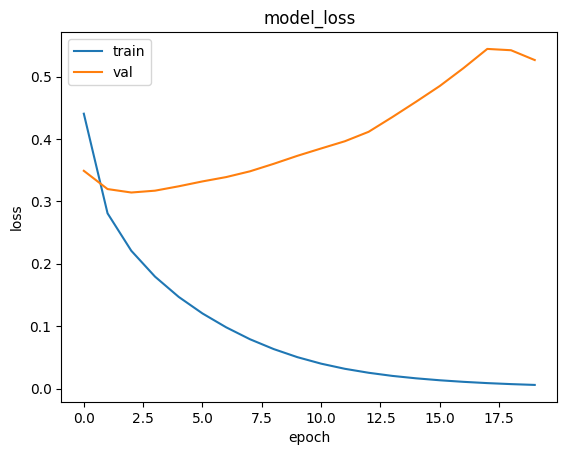

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

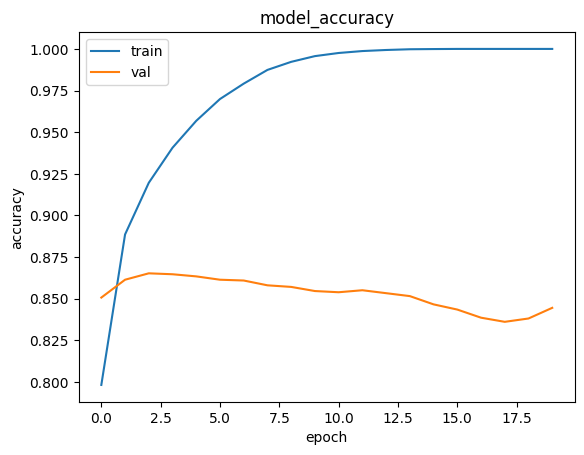

In [31]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━

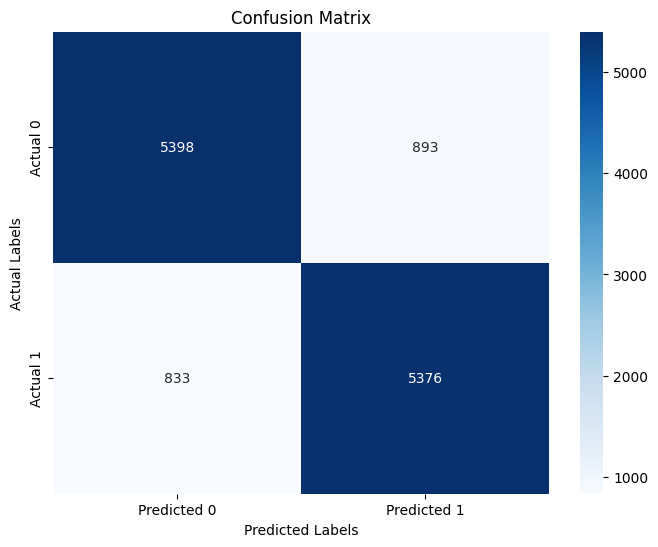

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Assuming 'val_dataset' is your validation dataset
# Get the true labels and model predictions for the validation set
y_true = []
y_pred = []

for x, y in val_dataset:
    predictions = transformer.predict(x)
    y_true.extend(y.numpy())  # Append true labels
    y_pred.extend(np.round(predictions).flatten())  # Append predicted labels (rounded to 0 or 1)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision, recall, F1 score, and confusion matrix
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print("Confusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()



# Evaluation


In [32]:
transformer.load_weights(checkpoint_filepath)


In [33]:

test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
transformer.evaluate(test_dataset)


196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8671 - loss: 0.3138


[0.3151642382144928, 0.864799976348877]

# Integrate LSHAttention in Transformer Model

Epoch 1/20


OperatorNotAllowedInGraphError: Exception encountered when calling LSHAttention.call().

[1mUsing a symbolic `tf.Tensor` as a Python `bool` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m

Arguments received by LSHAttention.call():
  • query=tf.Tensor(shape=(None, None, 128), dtype=float32)
  • key=tf.Tensor(shape=(None, None, 128), dtype=float32)
  • value=tf.Tensor(shape=(None, None, 128), dtype=float32)
  • causal_masking=False